In [3]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import warnings
from scipy.optimize import curve_fit
from scipy.stats import norm, lognorm
from scipy import integrate
import natural_cubic_spline_stack_overflow as ncs
import dynamic_stock_model as dsm 
warnings.simplefilter(action='ignore', category=FutureWarning)

## England's population - past, present, future

Sources: 
* Past population (1801-2016) = Our World in Data (OWID)
* Past population (1971-2022) = Office for National Statistics (ONS)


In [4]:
# Code from: 'Modelling.ipynb

def snsline(data,clm,clr,lbl,ttl,nm):
    ax = sns.lineplot(y=data[clm],x=data.index,label=lbl,color=clr)
    ax.set(xlabel=None, ylabel=None)
    ax.ticklabel_format(style='sci', axis='y')
    ax.set_title(ttl)
    fig = ax.get_figure()
    fig.savefig(nm,dpi=300,bbox_inches="tight")
    plt.show()
    return 

def snsline_cum(data,clm,clr,lbl,ttl,nm):
    ax = sns.lineplot(y=data[clm],x=data.index,label=lbl,color=clr)
    ax.set(xlabel=None, ylabel=None)
    ax.ticklabel_format(style='sci', axis='y')
    ax.set_title(ttl)
    fig = ax.get_figure()
    fig.savefig(nm,dpi=300,bbox_inches="tight")
    #plt.show()
    return 

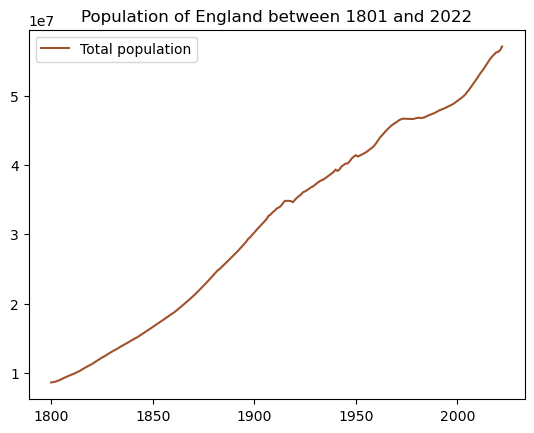

In [5]:
# Code from: 'Modelling.ipynb

# Sources: Our World in Data 

file = "Data/OWID/Population-of-england.csv"
pop_eng = pd.read_csv(file).drop(columns=['Entity','Code'])
pop_eng = pop_eng.set_index('Year')
pop_eng.columns = ['Population']
pop_eng.index.name = None
pop_eng_1801_2022 = pop_eng.loc[1800:2016,:]
#display(pop_eng_1801_2022)

# Sources: ONS / UK population estimates 

file = "Model/Population-total-1971-2022-UK.csv"
pop_eng = pd.read_csv(file).set_index('Unnamed: 0')
pop_eng.index.name = None
for i in np.arange(1971,2017):
    # taking the mean of both datas 
    pop_eng_1801_2022.loc[i,'Population'] = (pop_eng.loc[i,'Population']+pop_eng_1801_2022.loc[i,'Population'])/2
for i in np.arange(2017,2023):
    # completing 100% with this latest data 
    pop_eng_1801_2022.loc[i,'Population'] = pop_eng.loc[i,'Population']
#display(pop_eng_1801_2022)

snsline(pop_eng_1801_2022,'Population','sienna',"Total population","Population of England between 1801 and 2022","Output/Pop-Eng-1801-2022.png")

Let's complete with earlier population numbers

In [6]:
# Source: Wrigley and Schofield, "The Population History of England, 1541–1871. A reconstruction.", Harvard University Press, 1981, Table 7.8, pgs. 208-9
# http://www.localpopulationstudies.org.uk/PDF/LPS27/LPS27_1981_53-61.pdf

file = "Data/Research paper/Population-est-MA.xlsx"
pop_eng = pd.read_excel(file).set_index('Year')
pop_eng.index.name = None

#display(pop_eng)
#sns.lineplot(pop_eng,x=pop_eng.index,y='Population')

pop_eng_1600_1799 = pd.DataFrame(index=np.arange(1600,1802),columns=['Population'])

for i in np.arange(1600,1802):
    # Adding the pre-1800 numbers 
    if i in pop_eng.index:
        pop_eng_1600_1799.loc[i,'Population'] = pop_eng.loc[i,'Population']*10**6

# Missing values => interpolation

display(pop_eng_1600_1799)
pop_eng_1600_1799['Population'] = pd.to_numeric(pop_eng_1600_1799['Population'], errors='coerce')
pop_eng_1600_1799.interpolate(method='polynomial', order=2,axis=0,inplace=True)
pop_eng_1600_1799.loc[1600,'Population'] = pop_eng_1600_1799.loc[1601,'Population']-(pop_eng_1600_1799.loc[1602,'Population']-pop_eng_1600_1799.loc[1601,'Population'])
display(pop_eng_1600_1799)


,Population
1600,NaN
1601,4110000.0
1602,NaN
1603,NaN
1604,NaN
...,...
1797,NaN
1798,NaN
1799,NaN
1800,NaN


,Population
1600,4.084715e+06
1601,4.110000e+06
1602,4.135285e+06
1603,4.162227e+06
1604,4.190827e+06
...,...
1797,8.289975e+06
1798,8.382562e+06
1799,8.475762e+06
1800,8.569575e+06


Let's create the DSM with 5 dimensions: Total (`DSM`), AB (`DSM_AB`), MFH (`DSM_MFH`), SFH (`DSM_SFH`), TH (`DSM_TH`)

In [7]:
cols = ['Population','Stock','PpD','Stock change','Inflow','Outflow']
DSM = pd.DataFrame(index=np.arange(1600,2051),columns=cols)
DSM.index.name = 'DSM'
DSM_AB = pd.DataFrame(index=np.arange(1600,2051),columns=cols)
DSM_AB.index.name = 'DSM AB'
DSM_MFH = pd.DataFrame(index=np.arange(1600,2051),columns=cols)
DSM_MFH.index.name = 'DSM MFH'
DSM_SFH = pd.DataFrame(index=np.arange(1600,2051),columns=cols)
DSM_SFH.index.name = 'DSM SFH'
DSM_TH = pd.DataFrame(index=np.arange(1600,2051),columns=cols)
DSM_TH.index.name = 'DSM TH'

DSM_all = [DSM, DSM_AB, DSM_MFH, DSM_SFH, DSM_TH]

display(DSM)

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1600,NaN,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN


Let's fill in the past population

In [8]:
start = 1800
end = 2022
for i in np.arange(start,end+1):
    for dsm in DSM_all:
        dsm.loc[i,'Population'] = pop_eng_1801_2022.loc[i,'Population']

start = 1600
end = 1799
for i in np.arange(start,end+1):
    for dsm in DSM_all:
        dsm.loc[i,'Population'] = pop_eng_1600_1799.loc[i,'Population']

display(DSM.loc[1600:1605,])
display(DSM_TH.loc[1798:1805,])
display(DSM.loc[1860:1871,])
display(DSM_AB.loc[2018:2025,])

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1600,4084715.125107,NaN,NaN,NaN,NaN,NaN
1601,4110000.0,NaN,NaN,NaN,NaN,NaN
1602,4135284.874893,NaN,NaN,NaN,NaN,NaN
1603,4162227.31234,NaN,NaN,NaN,NaN,NaN
1604,4190827.31234,NaN,NaN,NaN,NaN,NaN
1605,4221084.874893,NaN,NaN,NaN,NaN,NaN


,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM TH,,,,,,
1798,8382561.979113,NaN,NaN,NaN,NaN,NaN
1799,8475761.979113,NaN,NaN,NaN,NaN,NaN
1800,8620000.0,NaN,NaN,NaN,NaN,NaN
1801,8671000.0,NaN,NaN,NaN,NaN,NaN
1802,8731000.0,NaN,NaN,NaN,NaN,NaN
1803,8832000.0,NaN,NaN,NaN,NaN,NaN
1804,8945000.0,NaN,NaN,NaN,NaN,NaN
1805,9092000.0,NaN,NaN,NaN,NaN,NaN


,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1860,18629000.0,NaN,NaN,NaN,NaN,NaN
1861,18833000.0,NaN,NaN,NaN,NaN,NaN
1862,19073000.0,NaN,NaN,NaN,NaN,NaN
1863,19315000.0,NaN,NaN,NaN,NaN,NaN
1864,19561000.0,NaN,NaN,NaN,NaN,NaN
1865,19810000.0,NaN,NaN,NaN,NaN,NaN
1866,20062000.0,NaN,NaN,NaN,NaN,NaN
1867,20317000.0,NaN,NaN,NaN,NaN,NaN
1868,20575000.0,NaN,NaN,NaN,NaN,NaN


,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM AB,,,,,,
2018,55924528.0,NaN,NaN,NaN,NaN,NaN
2019,56230056.0,NaN,NaN,NaN,NaN,NaN
2020,56325961.0,NaN,NaN,NaN,NaN,NaN
2021,56554891.0,NaN,NaN,NaN,NaN,NaN
2022,57106398.0,NaN,NaN,NaN,NaN,NaN
2023,NaN,NaN,NaN,NaN,NaN,NaN
2024,NaN,NaN,NaN,NaN,NaN,NaN
2025,NaN,NaN,NaN,NaN,NaN,NaN


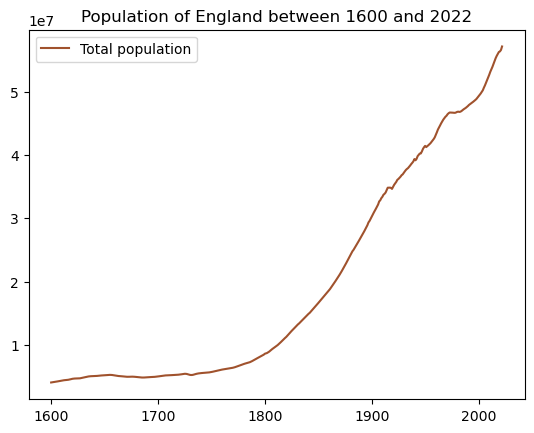

In [9]:
snsline(DSM,'Population','sienna',"Total population","Population of England between 1600 and 2022","Output/Pop-Eng-1600-2022.png")

Let's look at the projections

In [10]:
# Source : ONS UK population projections 
# https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationprojections/bulletins/nationalpopulationprojections/2021basedinterim#:~:text=2.-,UK%20population,(a%2010.2%25%20increase).

file = "Data/ONS - Population/UK_population_projected_ONS.xls"
pop_uk = pd.read_excel(file).drop(index=np.arange(0,6))
pop_uk.columns = ['Year','Population','Projection']
pop_uk = pop_uk.set_index('Year')
pop_uk.index.name = None
pop_uk.index = pop_uk.index.astype(int)

pro_uk = pop_uk.loc[2023:2046,:].drop(columns=['Population'])
pro_uk = pro_uk.rename(columns={'Projection':'Population'})
pro_uk['Population'] = pro_uk['Population'].astype(float)

pop_uk = pop_uk.loc[1996:2021,:].drop(columns=['Projection'])
pro_uk['Population'] = pro_uk['Population'].astype(float)
pop_uk.loc[1996,'Population'] = float(pop_uk.loc[1996,'Population'])

#display(pop_uk)
#print(type(pop_uk.loc[1996,'Population']))
#display(pro_uk)

# But here we got UK and we need ENG, therefore: 

#display(DSM)
ratio_eng_uk = DSM.loc[1996:2021,:'Population']
ratio_eng_uk.index.name = None
ratio_eng_uk['Population'] = ratio_eng_uk['Population'].astype(float)
#display(ratio_eng_uk)

for i in ratio_eng_uk.index:
    ratio_eng_uk.loc[i,'Population'] = ((pop_uk.loc[i,'Population'])*10**6)/ratio_eng_uk.loc[i,'Population']

#print(ratio_eng_uk)
ratio = ratio_eng_uk['Population'].mean()
print(ratio)

pro_eng = (pro_uk/ratio)*10**6

rate = pro_eng.loc[2046,'Population']-pro_eng.loc[2045,'Population']
for i in np.arange(2047,2051):
    pro_eng.loc[i,'Population'] = pro_eng.loc[i-1,'Population']+rate

display(pro_eng)

1.1923791045352061


,Population
2023,5.736431e+07
2024,5.786750e+07
2025,5.837070e+07
2026,5.887389e+07
2027,5.920936e+07
2028,5.954482e+07
2029,5.988028e+07
2030,6.013188e+07
2031,6.046735e+07
2032,6.071894e+07


In [11]:
start = 2023
end = 2050
for i in np.arange(start,end+1):
    for dsm in DSM_all:
        dsm.loc[i,'Population'] = pro_eng.loc[i,'Population']

display(DSM)

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1600,4084715.125107,NaN,NaN,NaN,NaN,NaN
1601,4110000.0,NaN,NaN,NaN,NaN,NaN
1602,4135284.874893,NaN,NaN,NaN,NaN,NaN
1603,4162227.31234,NaN,NaN,NaN,NaN,NaN
1604,4190827.31234,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,64241313.612971,NaN,NaN,NaN,NaN,NaN
2047,64492911.446965,NaN,NaN,NaN,NaN,NaN
2048,64744509.280958,NaN,NaN,NaN,NaN,NaN


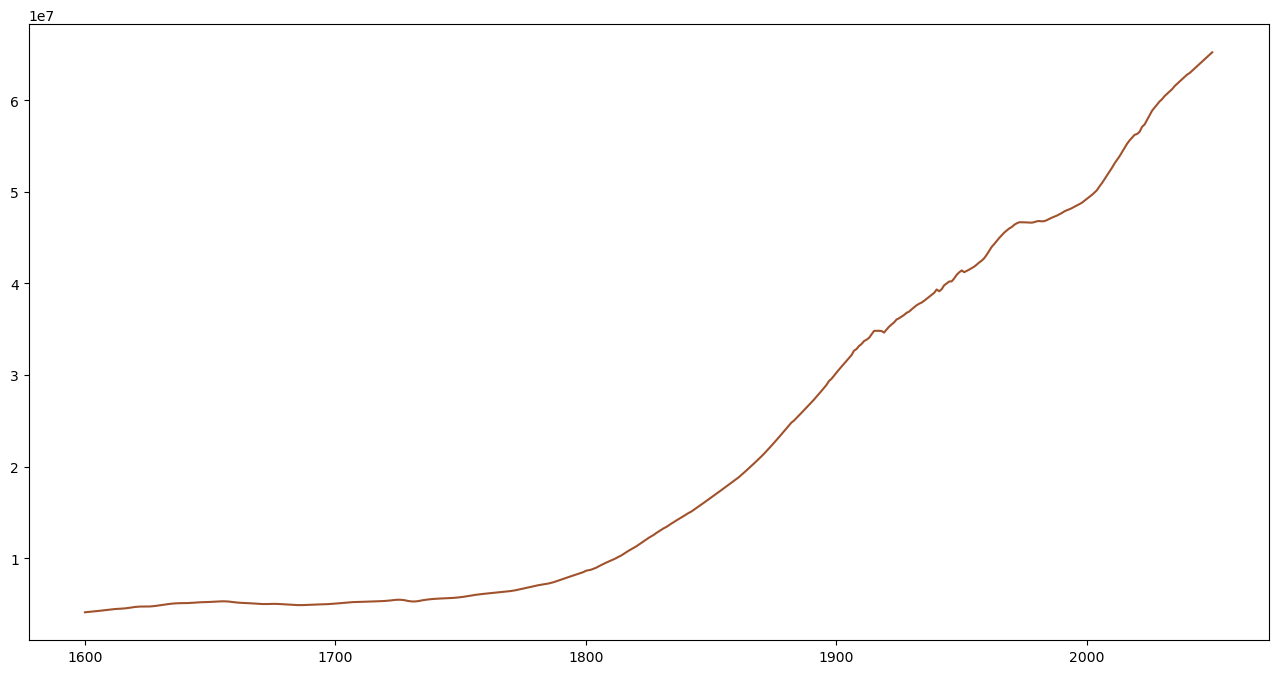

In [12]:
# snsline(DSM,'Population','sienna',"Total population","Population of England (incl. projections) between 1600 and 2050","Output/Pop-Eng-1600-2050.png")
# I don't want the title for the doc 

plt.figure(figsize=(16,8))
ax = sns.lineplot(y=DSM['Population'],x=DSM.index,color='sienna') # ,label="Total population"
ax.set(xlabel=None, ylabel=None)
ax.ticklabel_format(style='sci', axis='y')
#ax.set_title(ttl)
fig = ax.get_figure()
fig.savefig("Output/Population/Pop-Eng-1600-2050.png",dpi=300,bbox_inches="tight")
plt.show()

Logistic regression

In [13]:
def logistic(x:np.ndarray,ti:float,tau:float,C0:float,C1:float) -> np.ndarray:
    """
    General logistic function.
    Arguments:
    - x: np.ndarray of observation points (time)
    - ti: inflection time
    - tau: transition time coefficient
    - C0: start value
    - C1: end value

    Returns:
    - np.ndarray with len(x) number of points
    """
    return (C1 - C0)/(1 + np.exp(-(x - ti) / tau)) + C0 

In [14]:
inputs = DSM.index
outputs = DSM['Population']
pred_inputs = DSM.index

# it might be necessary to adjust the bounds argument, 
# determining the extreme acceptable value for the parameters of the logistic function.
# Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
popt, pcov = curve_fit(logistic, inputs, outputs, bounds = ([min(inputs), 0, 0, 0], [max(inputs), 10**9, 10**9, 10**9]))
pred_outputs = logistic(pred_inputs, *popt)

print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')

The optimal choice of parameters for the logistic function, given the sample data, is [1.93000941e+03 5.95984881e+01 3.52223618e+06 6.84621842e+07] (ti, tau, C0, C1).


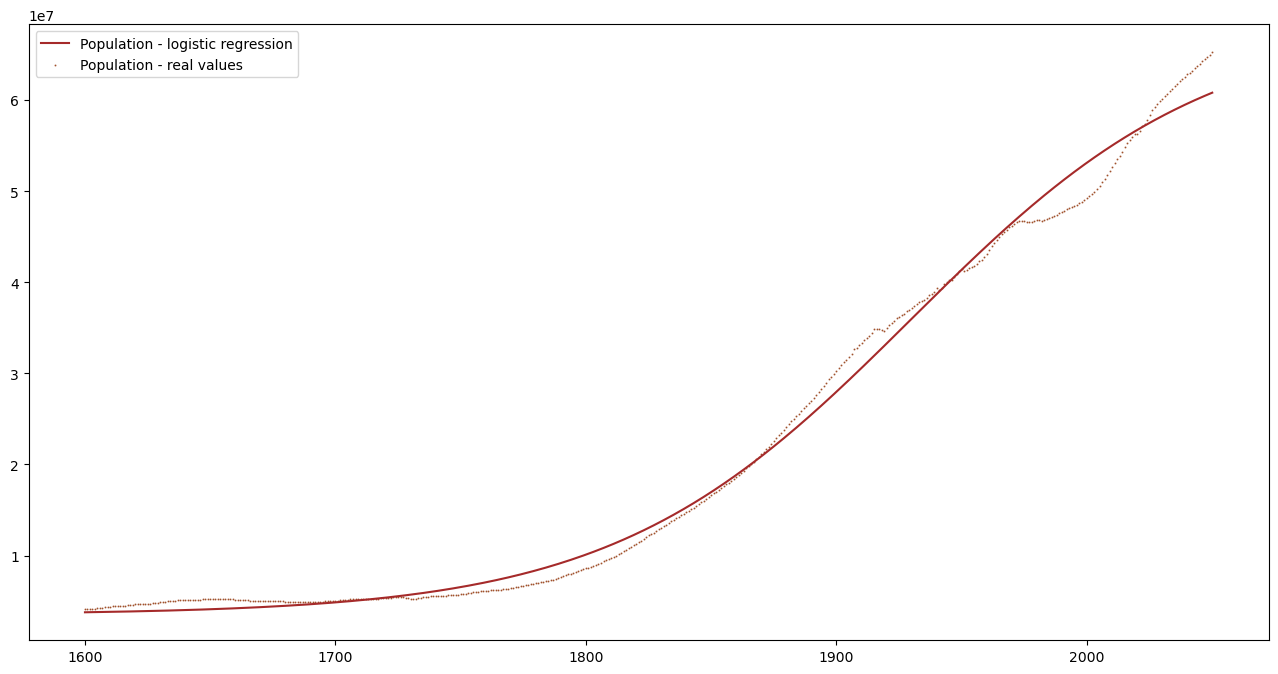

In [15]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(y=pred_outputs,x=DSM.index,color='brown',label="Population - logistic regression")
ax = sns.scatterplot(y=DSM['Population'],x=DSM.index,color='sienna',s=2,label="Population - real values") # ,label="Total population"
ax.set(xlabel=None, ylabel=None)
ax.ticklabel_format(style='sci', axis='y')
#ax.set_title(ttl)
fig = ax.get_figure()
fig.savefig("Output/Population/Pop-Eng-1600-2050-reg.png",dpi=300,bbox_inches="tight")
plt.show()

In [16]:
DSM['Population'] = pred_outputs

## Person per Dwelling (PPD)

Our other data gives us this:

In [17]:
# Data for validation of out stock modelling 
# Code from: Modelling.ipynb 

file = "Model/Stock-1801-2022.csv"
stock_eng = pd.read_csv(file).set_index('Year')

# Every 10 years until 1969 
# 1971 and 1981 are doubled because of crosisng two original datasets 

# We observe that 1971 is two times represented 
stock_eng = stock_eng.drop(index=[1971])
stock_eng = stock_eng.drop(index=[1981])
stock_eng.index.name = None
stock_eng.columns = ["Stock"]

display(stock_eng)
print('Stock in 2022 : ', stock_eng.loc[2022,'Stock'])
print('Population in 2022 : ', DSM.loc[2022,'Population'])


,Stock
1801,1.512000e+06
1811,1.714000e+06
1821,2.004000e+06
1831,2.420000e+06
1841,2.890000e+06
...,...
2018,2.421348e+07
2019,2.446124e+07
2020,2.470983e+07
2021,2.492759e+07


Stock in 2022 :  25160404.0
Population in 2022 :  57031048.22661879


In [18]:
"""
PpD_eng = stock_eng.copy(deep=True)
PpD_eng.columns = ['PpD']
for i in PpD_eng.index:
    PpD_eng.loc[i,'PpD'] = DSM.loc[i,'Population']/stock_eng.loc[i,'Stock']

PpD_eng.loc[1600,:] = [6] # chosen points 
PpD_eng.loc[2030,:] = [2.2] # chosen points 
PpD_eng.loc[2040,:] = [2.2] # chosen points 
PpD_eng.loc[2050,:] = [2.2] # chosen points 

display(PpD_eng)
print('PpD in 2022 : ', PpD_eng.loc[2022,'PpD'])
"""

"\nPpD_eng = stock_eng.copy(deep=True)\nPpD_eng.columns = ['PpD']\nfor i in PpD_eng.index:\n    PpD_eng.loc[i,'PpD'] = DSM.loc[i,'Population']/stock_eng.loc[i,'Stock']\n\nPpD_eng.loc[1600,:] = [6] # chosen points \nPpD_eng.loc[2030,:] = [2.2] # chosen points \nPpD_eng.loc[2040,:] = [2.2] # chosen points \nPpD_eng.loc[2050,:] = [2.2] # chosen points \n\ndisplay(PpD_eng)\nprint('PpD in 2022 : ', PpD_eng.loc[2022,'PpD'])\n"

,PpD
1996,2.41
2004,2.48
2012,2.62
2021,2.77


[5.073, 4.696, 4.776, 4.69, 4.74, 4.81, 4.77, 4.83, 4.47, 4.5, 4.61, 4.73, 4.62, 4.65, 4.14, 3.72, 3.19, 3.7]


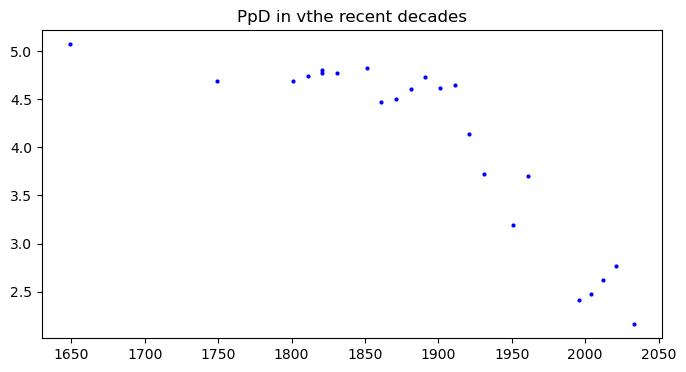

In [19]:
# Source: Statista 1996-2022 number of households by households size 
# https://www.statista.com/statistics/281627/households-in-the-united-kingdom-uk-by-size/
# Transformed

PpD_data = pd.DataFrame(index=[1996,2004,2012,2021],columns=['PpD'])
PpD_data['PpD'] = [2.41,2.48,2.62,2.77]
display(PpD_data)

PpD_data_2 = pd.read_excel("Data/Research paper/mean-hh-size.xlsx")
PpD_data_2.columns = ['Year','PpD']
PpD_data_2 = PpD_data_2.set_index('Year')
PpD_data_2.index.name = None
PpD_data_2 = PpD_data_2.drop(index=[1841,1941])
print(PpD_data_2['PpD'].to_list())

for i in PpD_data.index:
    PpD_data_2.loc[i,'PpD'] = PpD_data.loc[i,'PpD']
PpD_data_2.loc[2033,'PpD'] = 2.16
#PpD_data_2.loc[2033,'PpD'] = PpD_data_2.loc[2021,'PpD']+(PpD_data_2.loc[2021,'PpD']-PpD_data_2.loc[2012,'PpD'])
#PpD_data_2.loc[2050,'PpD'] = PpD_data_2.loc[2033,'PpD']+(PpD_data_2.loc[2033,'PpD']-PpD_data_2.loc[2021,'PpD'])

# display(PpD_data_2)

plt.figure(figsize=(8,4))
plt.plot(PpD_data_2.index, PpD_data_2["PpD"], 'o', color = 'blue', markersize = 2, label = f'PpD according to Statista (2023)')
plt.title('PpD in vthe recent decades')
plt.show()

PpD = pd.DataFrame(index=np.arange(1600,2051),columns=['PpD'])
#display(PpD)

In [20]:
degree = 3 
polynomial = np.poly1d(np.polyfit(PpD_data_2.index, PpD_data_2["PpD"], degree))
print(f' the polynomial our fit created is: \n{polynomial}.')
PpD_reg_data_2 = polynomial(DSM.index)

"""
degree = 5 # setting the degree
#find polynomial
polynomial = np.poly1d(np.polyfit(PpD_eng.index, PpD_eng["PpD"], degree))
print(f' the polynomial our fit created is: \n{polynomial}.')
#apply to extended values
PpD_reg_eng = polynomial(PpD.index)

plt.figure(figsize=(8,4))
plt.plot(PpD_data_2.index, PpD_data_2["PpD"], 's', color = 'blue', markersize = 2, label = f'true data PpD')
plt.plot(PpD.index, PpD_reg_data_2, color = 'cyan', lw = 1, label = f'polynomial regression (degree {degree}) values')
plt.plot(PpD_eng.index, PpD_eng["PpD"], 's', color = 'orange', markersize = 2, label = f'calculated PpD from stock')
plt.plot(PpD.index, PpD_reg_eng, color = 'yellow', lw = 1, label = f'polynomial regression (degree {degree}) values')
plt.title('polynomial regression on the PpD')
plt.legend()
plt.savefig('Output/PpD-evolution-1600-2050.png',dpi=300,bbox_inches='tight')
plt.show()
"""

print('2050 we end up at a PpD of:',PpD_reg_data_2[-1])
#print('2050 we end up at a PpD of:',PpD_reg_eng[-1])

 the polynomial our fit created is: 
            3             2
-9.951e-08 x + 0.0005168 x - 0.8953 x + 522.1.
2050 we end up at a PpD of: 1.517187115023603


The optimal choice of parameters for the logistic function, given the sample data, is [1937.28563655   10.            4.70839552    2.64250288] (ti, tau, C0, C1).


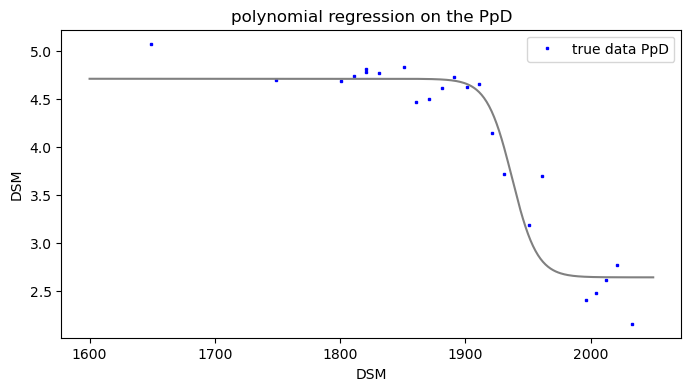

In [21]:
inputs = PpD_data_2.index
outputs = PpD_data_2['PpD']
pred_inputs = DSM.index

# it might be necessary to adjust the bounds argument, 
# determining the extreme acceptable value for the parameters of the logistic function.
# Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
popt, pcov = curve_fit(logistic, inputs, outputs, bounds = ([min(inputs), 0, 0, 0], [max(inputs), 10, 10, 10]))
pred_outputs = logistic(pred_inputs, *popt)

print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')

plt.figure(figsize=(8,4))
plt.plot(PpD_data_2.index, PpD_data_2["PpD"], 's', color = 'blue', markersize = 2, label = f'true data PpD')
#plt.plot(PpD_eng.index, PpD_eng["PpD"], 's', color = 'orange', markersize = 2, label = f'calculated PpD from stock')
ax = sns.lineplot(y=pred_outputs,x=DSM.index,color='gray')
plt.title('polynomial regression on the PpD')
plt.legend()
#plt.savefig('Output/PpD-evolution-1600-2050.png',dpi=300,bbox_inches='tight')
plt.show()

PpD['PpD'] = pred_outputs # Change to the right regression
#display(PpD)

PpD_calibrated = PpD.copy(deep=True)

# Calibration and validation of the stock below, with varying PpD numbers 

Calibration of our stock 

* 1921-1986 : our model is above real data 
* 1987-2022 = our model is (further) under real data 

The optimal choice of parameters for the logistic function, given the sample data, is [1941.07754291    8.75586344    4.7011322     2.59003884] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1943.55519117   10.96307109    4.70555481    2.4090971 ] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1945.4531308    12.35984909    4.70730425    2.35792652] (ti, tau, C0, C1).


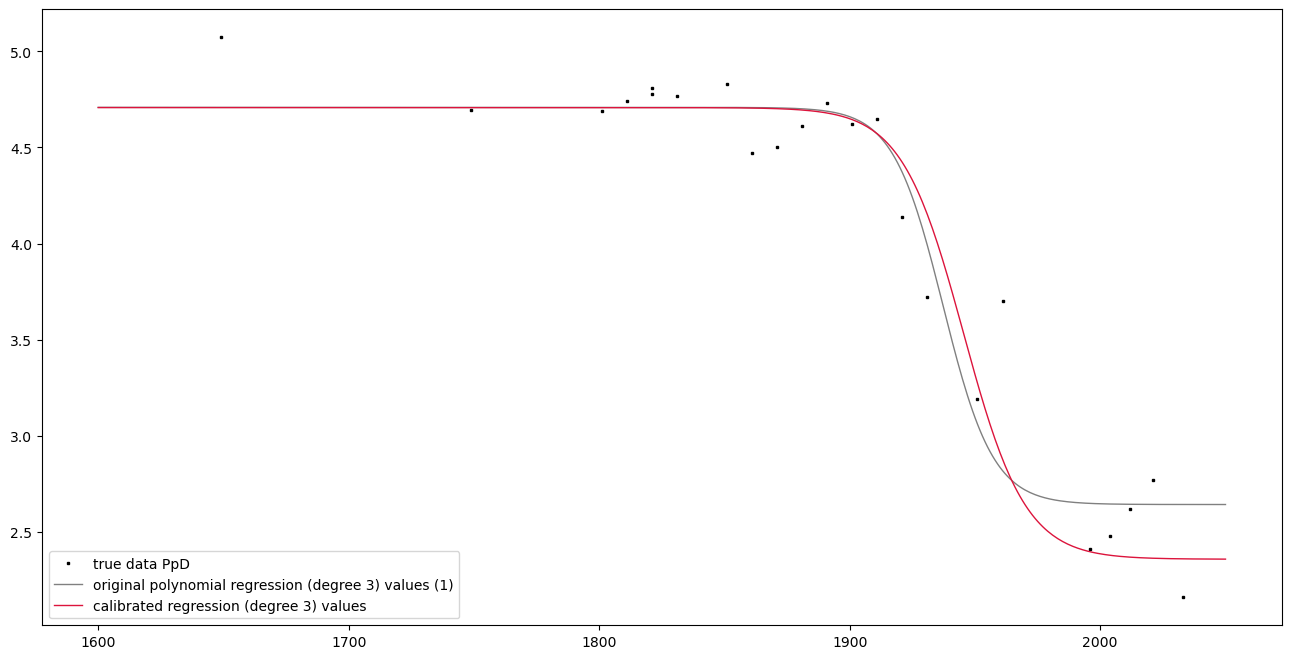

,PpD
1600,4.707304
1601,4.707304
1602,4.707304
1603,4.707304
1604,4.707304
...,...
2046,2.358615
2047,2.358561
2048,2.358512
2049,2.358467


In [22]:
# Do not run this cell if you do not want the calibrated stock

PpD_calibrated = PpD.copy(deep=True)

def calibration_PpD_middle(dystomod,PpD_cal,col,s,e,delta):
    mid = int((e+1-s)/2)
    diff = delta/mid
    add = diff
    for i in np.arange(s,s+mid+1):
        PpD_cal.loc[i,col] += add
        add += diff 
    for i in np.arange(s+mid,e+1):
        PpD_cal.loc[i,col] -= add
        add -= diff 
    inputs = PpD_cal.index
    outputs = PpD_cal[col]
    pred_inputs = dystomod.index
    # the max and mins below are proper to PpD typical values (careful if using def for other data type)
    popt, pcov = curve_fit(logistic, inputs, outputs, bounds = ([min(inputs), 0, 0, 0], [max(inputs), 100, 10, 10]))
    pred_outputs = logistic(pred_inputs, *popt)
    print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')
    PpD_cal['PpD'] = pred_outputs
    return PpD_cal

def calibration_PpD_end(dystomod,PpD_cal,col,s,e,delta):
    diff = delta/(e+1-s)
    add = diff
    for i in np.arange(s,e+1):
        PpD_cal.loc[i,col] += add
        add += diff 
    inputs = PpD_cal.index
    outputs = PpD_cal[col]
    pred_inputs = dystomod.index
    # the max and mins below are proper to PpD typical values (careful if using def for other data type)
    popt, pcov = curve_fit(logistic, inputs, outputs, bounds = ([min(inputs), 0, 0, 0], [max(inputs), 100, 10, 10]))
    pred_outputs = logistic(pred_inputs, *popt)
    print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')
    PpD_cal['PpD'] = pred_outputs
    return PpD_cal

cal_1_start = 1921
cal_1_end = 1986
delta_1 = +0.4

cal_2_start = 2010
cal_2_end = 2050
delta_2 = -0.6

cal_3_start = 1950
cal_3_end = 2000
delta_3 = +0.4

PpD_calibrated = calibration_PpD_middle(DSM,PpD_calibrated,'PpD',cal_1_start,cal_1_end,delta_1)
PpD_calibrated = calibration_PpD_end(DSM,PpD_calibrated,'PpD',cal_2_start,cal_2_end,delta_2)
PpD_calibrated = calibration_PpD_middle(DSM,PpD_calibrated,'PpD',cal_3_start,cal_3_end,delta_3)

plt.figure(figsize=(16,8))
plt.plot(PpD_data_2.index, PpD_data_2["PpD"], 's', color = 'black', markersize = 2, label = f'true data PpD')
plt.plot(PpD.index, PpD, color = 'gray', lw = 1, label = f'original polynomial regression (degree {degree}) values (1)')
plt.plot(PpD.index, PpD_calibrated, color = 'crimson', lw = 1, label = f'calibrated regression (degree {degree}) values')
#plt.title('polynomial regression on the PpD')
plt.legend(loc='lower left')
plt.savefig('Output/PpD/PpD-evolution-1600-2050.png',dpi=300,bbox_inches='tight')
plt.show()

display(PpD_calibrated)

Let's integrate this PpD into the DSM.
Important hypothesis here: we take the average PpD for each dwelling => no difference between AB, MFH in PpD...

In [23]:
for dsm in DSM_all:
    dsm['PpD'] = PpD_calibrated['PpD']
display(DSM)
display(DSM_AB)

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1600,3.776934e+06,NaN,4.707304,NaN,NaN,NaN
1601,3.781226e+06,NaN,4.707304,NaN,NaN,NaN
1602,3.785591e+06,NaN,4.707304,NaN,NaN,NaN
1603,3.790029e+06,NaN,4.707304,NaN,NaN,NaN
1604,3.794541e+06,NaN,4.707304,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,6.034675e+07,NaN,2.358615,NaN,NaN,NaN
2047,6.046516e+07,NaN,2.358561,NaN,NaN,NaN
2048,6.058207e+07,NaN,2.358512,NaN,NaN,NaN


,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM AB,,,,,,
1600,4084715.125107,NaN,4.707304,NaN,NaN,NaN
1601,4110000.0,NaN,4.707304,NaN,NaN,NaN
1602,4135284.874893,NaN,4.707304,NaN,NaN,NaN
1603,4162227.31234,NaN,4.707304,NaN,NaN,NaN
1604,4190827.31234,NaN,4.707304,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,64241313.612971,NaN,2.358615,NaN,NaN,NaN
2047,64492911.446965,NaN,2.358561,NaN,NaN,NaN
2048,64744509.280958,NaN,2.358512,NaN,NaN,NaN


## To the global stock

In [24]:
DSM['Stock'] = DSM['Population']/DSM['PpD']
display(DSM)
display(DSM_AB)

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1600,3.776934e+06,8.023560e+05,4.707304,NaN,NaN,NaN
1601,3.781226e+06,8.032679e+05,4.707304,NaN,NaN,NaN
1602,3.785591e+06,8.041951e+05,4.707304,NaN,NaN,NaN
1603,3.790029e+06,8.051378e+05,4.707304,NaN,NaN,NaN
1604,3.794541e+06,8.060963e+05,4.707304,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,6.034675e+07,2.558567e+07,2.358615,NaN,NaN,NaN
2047,6.046516e+07,2.563646e+07,2.358561,NaN,NaN,NaN
2048,6.058207e+07,2.568656e+07,2.358512,NaN,NaN,NaN


,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM AB,,,,,,
1600,4084715.125107,NaN,4.707304,NaN,NaN,NaN
1601,4110000.0,NaN,4.707304,NaN,NaN,NaN
1602,4135284.874893,NaN,4.707304,NaN,NaN,NaN
1603,4162227.31234,NaN,4.707304,NaN,NaN,NaN
1604,4190827.31234,NaN,4.707304,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,64241313.612971,NaN,2.358615,NaN,NaN,NaN
2047,64492911.446965,NaN,2.358561,NaN,NaN,NaN
2048,64744509.280958,NaN,2.358512,NaN,NaN,NaN


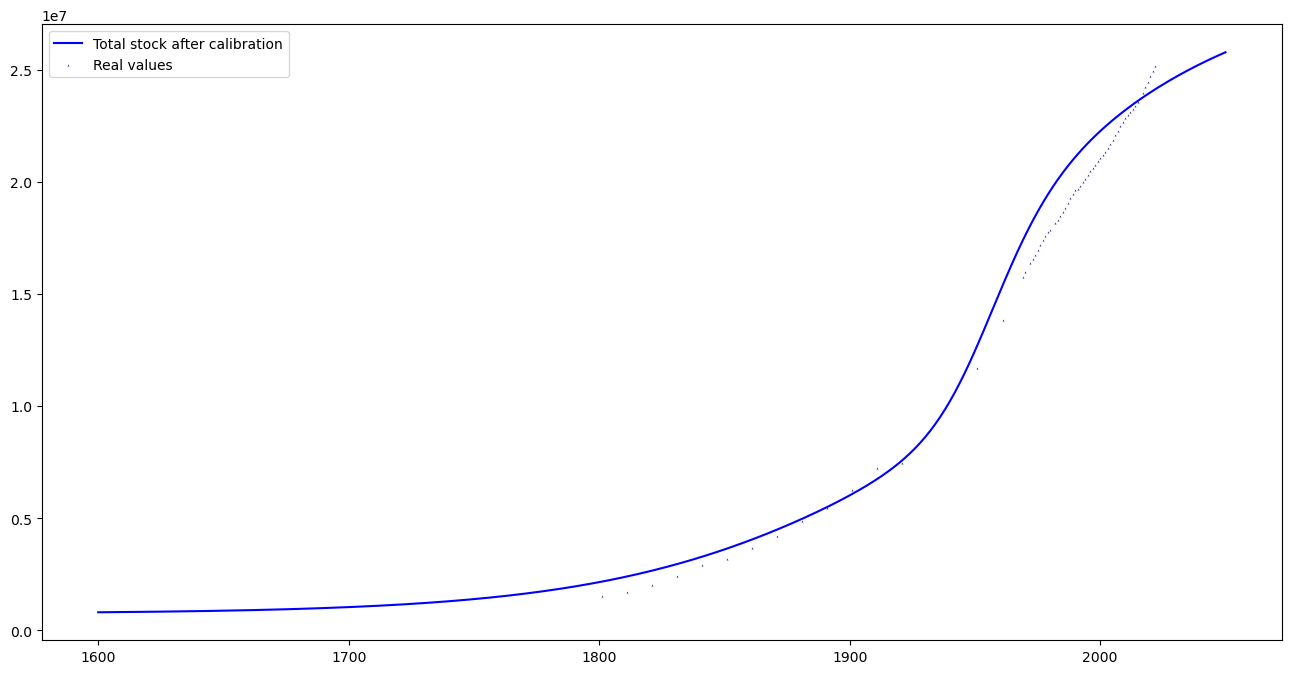

In [25]:
#Stock_before_calibration = DSM['Population']/PpD_reg
#plt.figure(figsize=(16,8))
#ax = sns.lineplot(y=Stock_before_calibration,x=DSM.index,label="Total stock before calibration",color='blue')
#ax = sns.scatterplot(y=stock_eng['Stock'],x=stock_eng.index,label="Real values",color='darkblue',s=2,marker='^') 
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
#ax.set(xlabel=None, ylabel=None)
#ax.ticklabel_format(style='sci', axis='y')
#ax.set_title(ttl)
#fig = ax.get_figure()
#fig.savefig("Output/Stock-for-evo-PpD-validation-1.png",dpi=300,bbox_inches="tight")
#plt.show()

plt.figure(figsize=(16,8))
ax = sns.lineplot(y=DSM['Stock'],x=DSM.index,label="Total stock after calibration",color='blue')
ax = sns.scatterplot(y=stock_eng['Stock'],x=stock_eng.index,label="Real values",color='darkblue',s=2,marker='^') 
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
ax.set(xlabel=None, ylabel=None)
ax.ticklabel_format(style='sci', axis='y')
#ax.set_title(ttl)
fig = ax.get_figure()
fig.savefig("Output/Stock/Stock-for-evo-PpD-validation-2.png",dpi=300,bbox_inches="tight")
plt.show()

#display(stock_eng.index)

def shift(realdata,model,start,end,col):
    for i in realdata.index[start:end]:
        print(i,realdata.loc[i,col]>model.loc[i,col])

#shift(stock_eng,DSM,29,40,'Stock')

In [26]:
display(DSM_all)

TYP = ['TOT','AB','MFH','SFH','TH']
for k in np.arange(0,5):
    dsm = DSM_all[k]
    typ = TYP[k]
    dsm.to_csv("Model/DSM_"+typ+".csv")
    i += 1

[        Population         Stock       PpD Stock change Inflow Outflow
 DSM                                                                   
 1600  3.776934e+06  8.023560e+05  4.707304          NaN    NaN     NaN
 1601  3.781226e+06  8.032679e+05  4.707304          NaN    NaN     NaN
 1602  3.785591e+06  8.041951e+05  4.707304          NaN    NaN     NaN
 1603  3.790029e+06  8.051378e+05  4.707304          NaN    NaN     NaN
 1604  3.794541e+06  8.060963e+05  4.707304          NaN    NaN     NaN
 ...            ...           ...       ...          ...    ...     ...
 2046  6.034675e+07  2.558567e+07  2.358615          NaN    NaN     NaN
 2047  6.046516e+07  2.563646e+07  2.358561          NaN    NaN     NaN
 2048  6.058207e+07  2.568656e+07  2.358512          NaN    NaN     NaN
 2049  6.069751e+07  2.573601e+07  2.358467          NaN    NaN     NaN
 2050  6.081149e+07  2.578479e+07  2.358425          NaN    NaN     NaN
 
 [451 rows x 6 columns],
              Population Stock       

## Stock for each type of dwelling

Introducing the EPISCODE / TABULA DATA 

In [27]:
# figure S-1.1. from EPISCOBE GB: number of dwellings in 2013 

typ = ['SFH','MFH','TH','AB']
dat = ['pre 1919','1919-1944','1945-1964','1965-1980','1981-1990','1991- 2003','2004-2013']

EPISCOPE_TYP_freq = pd.DataFrame(index = typ, columns = dat)

#                                   SFH     MFH       TH      AB 
EPISCOPE_TYP_freq['pre 1919'] = [615*1000,982*1000,3259*1000,None]
EPISCOPE_TYP_freq['1919-1944'] = [567*1000,314*1000,2811*1000,None]
EPISCOPE_TYP_freq['1945-1964'] = [746*1000,595*1000,3026*1000,82*1000]
EPISCOPE_TYP_freq['1965-1980'] = [1206*1000,952*1000,2291*1000,188*1000]
EPISCOPE_TYP_freq['1981-1990'] = [767*1000,459*1000,695*1000,None]
EPISCOPE_TYP_freq['1991- 2003'] = [785*1000,391*1000,716*1000,None]
EPISCOPE_TYP_freq['2004-2013'] = [214*1000,296*1000,293*1000,49*1000]

display(EPISCOPE_TYP_freq)

EPISCOPE_TYP_spac = pd.DataFrame(index = typ, columns = dat)

# figure S-1.1. from EPISCOBE GB: living space in m2 in 2013 

#                                   SFH     MFH       TH      AB 
EPISCOPE_TYP_spac['pre 1919'] = [117528*1000,66539*1000,318723*1000,701*1000]
EPISCOPE_TYP_spac['1919-1944'] = [81900*1000,18963*1000,246106*1000,1131*1000]
EPISCOPE_TYP_spac['1945-1964'] = [95836*1000,33802*1000,248479*1000,4556*1000]
EPISCOPE_TYP_spac['1965-1980'] = [142846*1000,53172*1000,184076*1000,10789*1000]
EPISCOPE_TYP_spac['1981-1990'] = [91836*1000,22455*1000,47710*1000,723*1000]
EPISCOPE_TYP_spac['1991- 2003'] = [103807*1000,20698*1000,53674*1000,1252*1000]
EPISCOPE_TYP_spac['2004-2013'] = [30281*1000,16835*1000,26630*1000,2981*1000]

display(EPISCOPE_TYP_spac)

,pre 1919,1919-1944,1945-1964,1965-1980,1981-1990,1991- 2003,2004-2013
SFH,615000.0,567000.0,746000,1206000,767000.0,785000.0,214000
MFH,982000.0,314000.0,595000,952000,459000.0,391000.0,296000
TH,3259000.0,2811000.0,3026000,2291000,695000.0,716000.0,293000
AB,NaN,NaN,82000,188000,NaN,NaN,49000


,pre 1919,1919-1944,1945-1964,1965-1980,1981-1990,1991- 2003,2004-2013
SFH,117528000,81900000,95836000,142846000,91836000,103807000,30281000
MFH,66539000,18963000,33802000,53172000,22455000,20698000,16835000
TH,318723000,246106000,248479000,184076000,47710000,53674000,26630000
AB,701000,1131000,4556000,10789000,723000,1252000,2981000


,Dwelling size
1945,55.560976
1965,57.388298
2004,60.836735


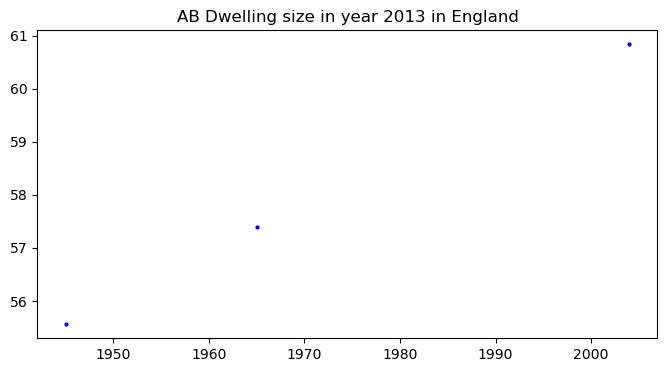

 the polynomial our fit created is: 
            2
-4.991e-05 x + 0.2865 x - 312.9.


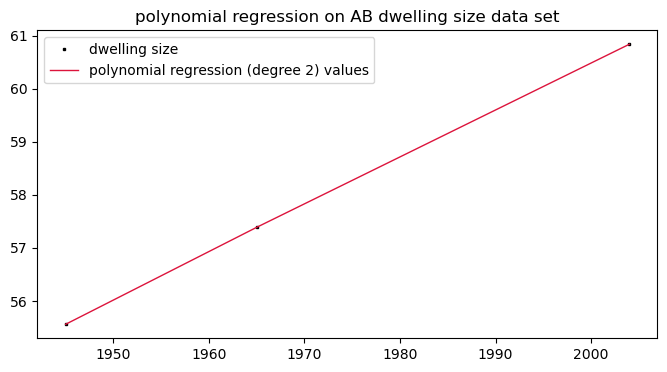

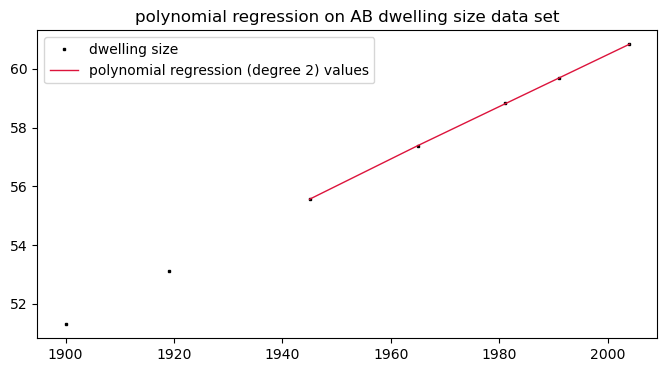

,pre 1919,1919-1944,1945-1964,1965-1980,1981-1990,1991- 2003,2004-2013
SFH,6.150000e+05,5.670000e+05,746000,1206000,767000.000000,785000.000000,214000
MFH,9.820000e+05,3.140000e+05,595000,952000,459000.000000,391000.000000,296000
TH,3.259000e+06,2.811000e+06,3026000,2291000,695000.000000,716000.000000,293000
AB,1.366378e+04,2.128911e+04,82000,188000,12291.443309,20970.075302,49000


In [28]:
s1 = EPISCOPE_TYP_spac.loc['AB','1945-1964']/EPISCOPE_TYP_freq.loc['AB','1945-1964']
s2 = EPISCOPE_TYP_spac.loc['AB','1965-1980']/EPISCOPE_TYP_freq.loc['AB','1965-1980']
s3 = EPISCOPE_TYP_spac.loc['AB','2004-2013']/EPISCOPE_TYP_freq.loc['AB','2004-2013']

dates = [1945,1965,2004]
AB_size = [s1,s2,s3]

AB_size_evolution = pd.DataFrame(index=dates,columns=["Dwelling size"])
AB_size_evolution["Dwelling size"] = AB_size

display(AB_size_evolution)

plt.figure(figsize=(8,4))
plt.plot(AB_size_evolution.index, AB_size_evolution["Dwelling size"], 'o', color = 'blue', markersize = 2, label = f'Dwelling size')
plt.title('AB Dwelling size in year 2013 in England')
plt.show()

degree = 2 # setting the degree
#find polynomial
polynomial = np.poly1d(np.polyfit(AB_size_evolution.index, AB_size_evolution["Dwelling size"], degree))
print(f' the polynomial our fit created is: \n{polynomial}.')
#apply to extended values
AB_size_evolution_reg = polynomial(AB_size_evolution.index)
plt.figure(figsize=(8,4))
plt.plot(AB_size_evolution.index, AB_size_evolution["Dwelling size"], 's', color = 'black', markersize = 2, label = f'dwelling size')
plt.plot(AB_size_evolution.index, AB_size_evolution_reg, color = 'crimson', lw = 1, label = f'polynomial regression (degree {degree}) values')
plt.title('polynomial regression on AB dwelling size data set')
plt.legend()
plt.show()

#display(AB_size_evolution_reg)
#display(polynomial)

# We can now approximate the size of the dwellings depending on there average year of construction

dates = [1900,1919,1945,1965,1981,1991,2004]
AB_size = [polynomial(1900),polynomial(1919),s1,s2,polynomial(1981),polynomial(1991),s3]
AB_size_evolution_approx = pd.DataFrame(index=dates,columns=["Dwelling size"])
AB_size_evolution_approx["Dwelling size"] = AB_size

plt.figure(figsize=(8,4))
plt.plot(AB_size_evolution_approx.index, AB_size_evolution_approx["Dwelling size"], 's', color = 'black', markersize = 2, label = f'dwelling size')
plt.plot(AB_size_evolution.index, AB_size_evolution_reg, color = 'crimson', lw = 1, label = f'polynomial regression (degree {degree}) values')
plt.title('polynomial regression on AB dwelling size data set')
plt.legend()
plt.show()

EPISCOPE_TYP_freq.loc['AB','pre 1919'] = EPISCOPE_TYP_spac.loc['AB','pre 1919']/AB_size_evolution_approx.loc[1900,'Dwelling size']
EPISCOPE_TYP_freq.loc['AB','1919-1944'] = EPISCOPE_TYP_spac.loc['AB','1919-1944']/AB_size_evolution_approx.loc[1919,'Dwelling size']
EPISCOPE_TYP_freq.loc['AB','1981-1990'] = EPISCOPE_TYP_spac.loc['AB','1981-1990']/AB_size_evolution_approx.loc[1981,'Dwelling size']
EPISCOPE_TYP_freq.loc['AB','1991- 2003'] = EPISCOPE_TYP_spac.loc['AB','1991- 2003']/AB_size_evolution_approx.loc[1991,'Dwelling size']

display(EPISCOPE_TYP_freq)

,pre 1919,1919-1944,1945-1964,1965-1980,1981-1990,1991- 2003,2004-2013
SFH,6.150000e+05,5.670000e+05,746000,1206000,767000.000000,785000.000000,214000
MFH,9.820000e+05,3.140000e+05,595000,952000,459000.000000,391000.000000,296000
TH,3.259000e+06,2.811000e+06,3026000,2291000,695000.000000,716000.000000,293000
AB,1.366378e+04,2.128911e+04,82000,188000,12291.443309,20970.075302,49000


pre 1919      4.869664e+06
1919-1944     3.713289e+06
1945-1964     4.449000e+06
1965-1980     4.637000e+06
1981-1990     1.933291e+06
1991- 2003    1.912970e+06
2004-2013     8.520000e+05
dtype: float64

,pre 1919,1919-1944,1945-1964,1965-1980,1981-1990,1991- 2003,2004-2013
SFH,0.126292,0.152695,0.167678,0.260082,0.396733,0.410357,0.251174
MFH,0.201657,0.084561,0.133738,0.205305,0.237419,0.204394,0.347418
TH,0.669245,0.757011,0.680153,0.494069,0.359491,0.374287,0.343897
AB,0.002806,0.005733,0.018431,0.040543,0.006358,0.010962,0.057512


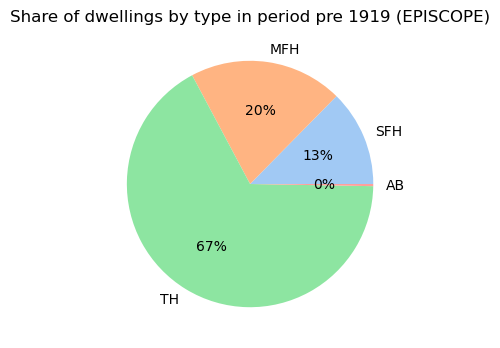

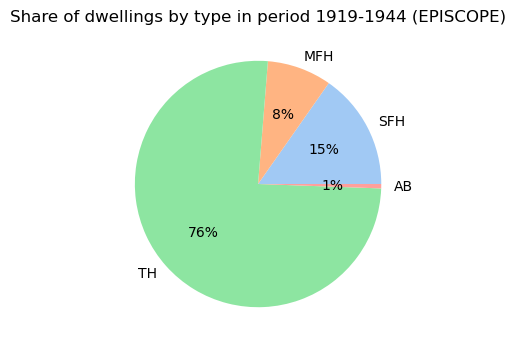

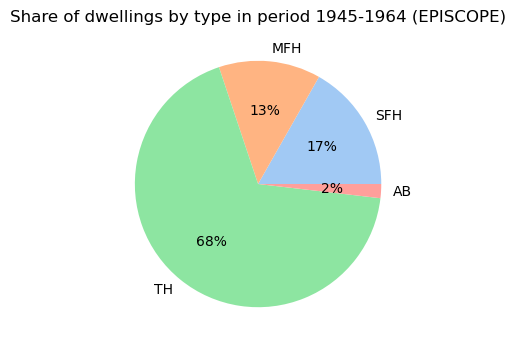

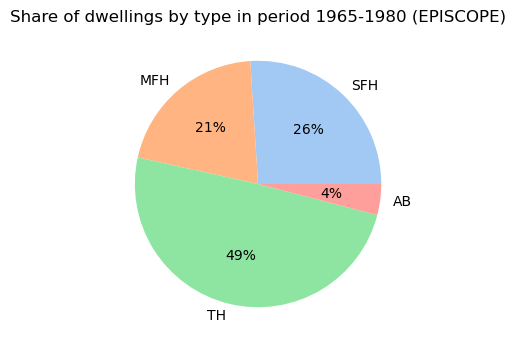

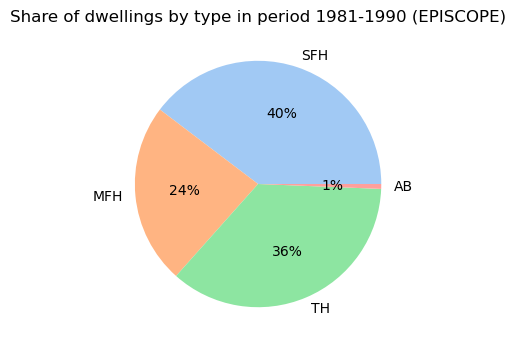

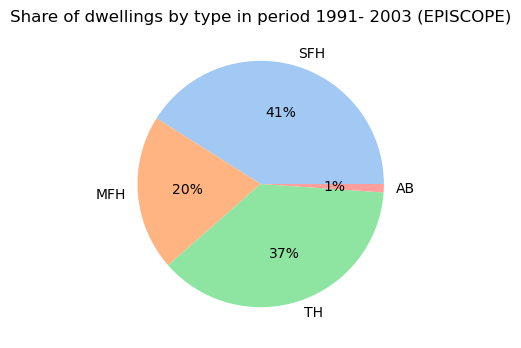

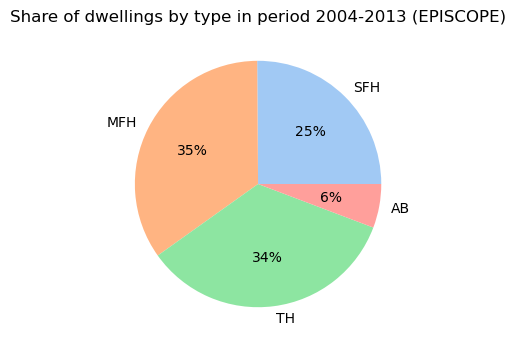

,SFH,MFH,TH,AB
1900,0.126292,0.201657,0.669245,0.002806
1931,0.152695,0.084561,0.757011,0.005733
1954,0.167678,0.133738,0.680153,0.018431
1972,0.260082,0.205305,0.494069,0.040543
1985,0.396733,0.237419,0.359491,0.006358
1997,0.410357,0.204394,0.374287,0.010962
2008,0.251174,0.347418,0.343897,0.057512


In [29]:
display(EPISCOPE_TYP_freq)
display(EPISCOPE_TYP_freq.sum(axis=0))

# Let's assume that all have a similar lifespan => the difference in share across time can be reinjected in our above model.

EPISCOPE_TYP_freq_share = EPISCOPE_TYP_freq.copy(deep=True)
for i in EPISCOPE_TYP_freq_share.index:
    for j in EPISCOPE_TYP_freq_share.columns:
        EPISCOPE_TYP_freq_share.loc[i,j] = EPISCOPE_TYP_freq.loc[i,j]/EPISCOPE_TYP_freq.sum(axis=0)[j]

display(EPISCOPE_TYP_freq_share)

colors = sns.color_palette('pastel')[0:5]
for periods in EPISCOPE_TYP_freq_share.columns:
    plt.figure(figsize=(4,4))
    plt.pie(EPISCOPE_TYP_freq_share[periods], labels = EPISCOPE_TYP_freq_share.index, colors = colors, autopct='%.0f%%')
    plt.title('Share of dwellings by type in period ' + periods + ' (EPISCOPE)')
    plt.savefig('Output/Share-by-type-'+periods+'.png',dpi=300,bbox_inches='tight')
    plt.show()

a = int((1919+1944)/2)
b = int((1945+1964)/2)
c = int((1965+1980)/2)
d = int((1981+1990)/2)
e = int((1991+2003)/2)
f = int((2004+2013)/2)
EPISCOPE_TYP_freq_share.columns=[1900,a,b,c,d,e,f]
EPISCOPE_TYP_freq_share = EPISCOPE_TYP_freq_share.T
display(EPISCOPE_TYP_freq_share)

,SFH,MFH,TH,AB
1900,0.126292,0.201657,0.669245,0.002806
1931,0.152695,0.084561,0.757011,0.005733
1954,0.167678,0.133738,0.680153,0.018431
1972,0.260082,0.205305,0.494069,0.040543
1985,0.396733,0.237419,0.359491,0.006358
1997,0.410357,0.204394,0.374287,0.010962
2008,0.251174,0.347418,0.343897,0.057512
1600,0.320000,0.350000,0.350000,-0.020000


 the polynomial our fit created is: 
           2
6.284e-07 x - 0.002131 x + 1.782.
 the polynomial our fit created is: 
          2
5.47e-06 x - 0.01993 x + 18.24.
 the polynomial our fit created is: 
          2
7.26e-06 x - 0.02608 x + 23.47.
 the polynomial our fit created is: 
            2
-1.336e-05 x + 0.04814 x - 42.48.


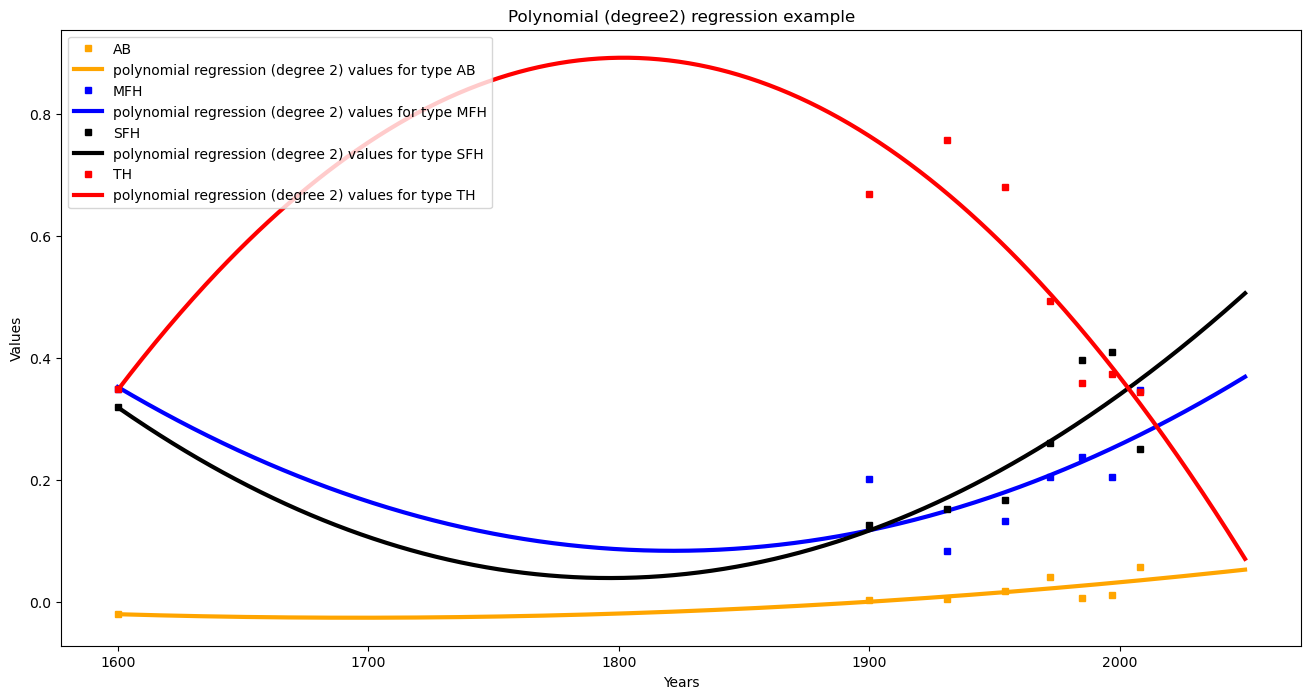

,SFH,MFH,TH,AB
DSM,,,,
1600,0.319402,0.352725,0.347738,-0.019865
1601,0.316558,0.350306,0.35312,-0.019985
1602,0.313729,0.347898,0.358476,-0.020103
1603,0.310914,0.345501,0.363805,-0.02022
1604,0.308114,0.343115,0.369108,-0.020336
...,...,...,...,...
2046,0.49182,0.359541,0.097198,0.05144
2047,0.495452,0.362002,0.090666,0.051881
2048,0.499098,0.364473,0.084106,0.052323


,SFH,MFH,TH,AB
DSM,,,,
1600,0.313181,0.345855,0.340964,0.0
1601,0.310356,0.343442,0.346202,0.0
1602,0.307546,0.341042,0.351412,0.0
1603,0.304752,0.338653,0.356595,0.0
1604,0.301973,0.336276,0.361751,0.0
...,...,...,...,...
2046,0.49182,0.359541,0.097198,0.05144
2047,0.495452,0.362002,0.090666,0.051881
2048,0.499098,0.364473,0.084106,0.052323


In [30]:
EPISCOPE_TYP_freq_share.loc[1600] = [0.3,0.35,0.35,0.0]
EPISCOPE_TYP_freq_share.loc[1600] = [0.32,0.35,0.35,-0.02] # TAKE THE ONE BEFORE IF NEEDED - minus share to avoid 0.124 if zero
display(EPISCOPE_TYP_freq_share)

"""
inputs = EPISCOPE_TYP_freq_share.index
outputs_SFH = EPISCOPE_TYP_freq_share['SFH']
outputs_MFH = EPISCOPE_TYP_freq_share['MFH']
outputs_TH = EPISCOPE_TYP_freq_share['TH']
outputs_AB = EPISCOPE_TYP_freq_share['AB']
pred_inputs = DSM.index
degree = 2
polynomial_S = np.poly1d(np.polyfit(inputs, outputs_SFH, degree))
polynomial_M = np.poly1d(np.polyfit(inputs, outputs_MFH, degree))
polynomial_T = np.poly1d(np.polyfit(inputs, outputs_TH, degree))
polynomial_A = np.poly1d(np.polyfit(inputs, outputs_AB, degree))
print(f' the polynomial our fit created is: \n{polynomial}.')
#apply to extended values
pred_outputs_S = polynomial_S(pred_inputs)
pred_outputs_M = polynomial_M(pred_inputs)
pred_outputs_T = polynomial_T(pred_inputs)
pred_outputs_A = polynomial_A(pred_inputs)
fig=plt.figure(figsize = (16,8))
plt.plot(inputs, outputs_SFH, 's', color = 'black', markersize = 5, label = f'SFH')
plt.plot(inputs, outputs_MFH, 's', color = 'blue', markersize = 5, label = f'MFH')
plt.plot(inputs, outputs_TH, 's', color = 'red', markersize = 5, label = f'TH')
plt.plot(inputs, outputs_AB, 's', color = 'orange', markersize = 5, label = f'AB')
plt.plot(pred_inputs, pred_outputs_S, color = 'black', lw = 3,label = f'polynomial regression (degree {degree}) values')
plt.plot(pred_inputs, pred_outputs_M, color = 'blue', lw = 3, label = f'polynomial regression (degree {degree}) values')
plt.plot(pred_inputs, pred_outputs_T, color = 'red', lw = 3, label = f'polynomial regression (degree {degree}) values')
plt.plot(pred_inputs, pred_outputs_A, color = 'orange', lw = 3, label = f'polynomial regression (degree {degree}) values')
plt.legend(loc = 'upper left')
plt.title(f'Polynomial (degree{degree}) regression example')
plt.xlabel('Years')
plt.ylabel('Values')
plt.show()
"""

def reg_on_type_shares(freq_share,dwe_type,dywtomod,degr,color):
    #inputs = freq_share.index
    #outputs = freq_share[dwe_type]
    #reg_inputs = dywtomod.index
    #degree = deg
    polynomial = np.poly1d(np.polyfit(freq_share.index, freq_share[dwe_type], degr))
    print(f' the polynomial our fit created is: \n{polynomial}.')
    regression = polynomial(dywtomod.index)
    #fig=plt.figure(figsize = (16,8))
    plt.plot(freq_share.index, freq_share[dwe_type], 's', color = color, markersize = 5, label = dwe_type)
    plt.plot(dywtomod.index, regression, color = color, lw = 3,label = f'polynomial regression (degree {degree}) values for type {dwe_type}')
    #plt.legend(loc = 'upper left')
    #plt.title(f'Polynomial (degree{degree}) regression example')
    #plt.xlabel('Years')
    #plt.ylabel('Values')
    return regression 

fig=plt.figure(figsize = (16,8))
reg_share_AB = reg_on_type_shares(EPISCOPE_TYP_freq_share,'AB',DSM,2,'orange')
reg_share_MFH = reg_on_type_shares(EPISCOPE_TYP_freq_share,'MFH',DSM,2,'blue')
reg_share_SFH = reg_on_type_shares(EPISCOPE_TYP_freq_share,'SFH',DSM,2,'black')
reg_share_TH = reg_on_type_shares(EPISCOPE_TYP_freq_share,'TH',DSM,2,'red')
plt.legend(loc = 'upper left')
plt.title(f'Polynomial (degree{degree}) regression example')
plt.xlabel('Years')
plt.ylabel('Values')
plt.show()

EPISCOPE_TYP_share_model = pd.DataFrame(index=DSM.index,columns=EPISCOPE_TYP_freq_share.columns)
start = EPISCOPE_TYP_share_model.index[0]
for i in EPISCOPE_TYP_share_model.index:
    EPISCOPE_TYP_share_model.loc[i] = [reg_share_SFH[i-start],reg_share_MFH[i-start],reg_share_TH[i-start],reg_share_AB[i-start]]
display(EPISCOPE_TYP_share_model)

# Let's 1/ Put all numbers into the (0,1) boundaries and 2/ make sure the total is equal to 1 
for i in EPISCOPE_TYP_share_model.index:
    for j in EPISCOPE_TYP_share_model.columns:
        if EPISCOPE_TYP_share_model.loc[i,j] < 0:
            EPISCOPE_TYP_share_model.loc[i,j] = 0
        if EPISCOPE_TYP_share_model.loc[i,j] > 1:
            EPISCOPE_TYP_share_model.loc[i,j] = 1

for i in EPISCOPE_TYP_share_model.index:
    EPISCOPE_TYP_share_model.loc[i] = EPISCOPE_TYP_share_model.loc[i]/EPISCOPE_TYP_share_model.sum(axis=1)[i]
    
"""
for i in EPISCOPE_TYP_share_model.index:
    for j in EPISCOPE_TYP_share_model.columns:
        print(EPISCOPE_TYP_share_model.loc[i,j])
        EPISCOPE_TYP_share_model.loc[i,j] = EPISCOPE_TYP_share_model.loc[i,j]/EPISCOPE_TYP_share_model.sum(axis=1)[i]
        print(EPISCOPE_TYP_share_model.loc[i,j])
"""

display(EPISCOPE_TYP_share_model)
#display(EPISCOPE_TYP_share_model.sum(axis=1))

EPISCOPE_TYP_share_model.to_csv("Model/EPISCOPE-dwe-type-shares-in-time.csv")

In [33]:
display(EPISCOPE_TYP_share_model)
EPISCOPE_TYP_share_model.to_csv("Model/modelled-types-by-share-1600-2050.csv")

,SFH,MFH,TH,AB
DSM,,,,
1600,0.313181,0.345855,0.340964,0.0
1601,0.310356,0.343442,0.346202,0.0
1602,0.307546,0.341042,0.351412,0.0
1603,0.304752,0.338653,0.356595,0.0
1604,0.301973,0.336276,0.361751,0.0
...,...,...,...,...
2046,0.49182,0.359541,0.097198,0.05144
2047,0.495452,0.362002,0.090666,0.051881
2048,0.499098,0.364473,0.084106,0.052323


,SFH,MFH,TH,AB
DSM,,,,
1600,0.313181,0.345855,0.340964,0.0
1601,0.310356,0.343442,0.346202,0.0
1602,0.307546,0.341042,0.351412,0.0
1603,0.304752,0.338653,0.356595,0.0
1604,0.301973,0.336276,0.361751,0.0
...,...,...,...,...
2046,0.49182,0.359541,0.097198,0.05144
2047,0.495452,0.362002,0.090666,0.051881
2048,0.499098,0.364473,0.084106,0.052323


,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1600,3.776934e+06,8.023560e+05,4.707304,NaN,NaN,NaN
1601,3.781226e+06,8.032679e+05,4.707304,NaN,NaN,NaN
1602,3.785591e+06,8.041951e+05,4.707304,NaN,NaN,NaN
1603,3.790029e+06,8.051378e+05,4.707304,NaN,NaN,NaN
1604,3.794541e+06,8.060963e+05,4.707304,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,6.034675e+07,2.558567e+07,2.358615,NaN,NaN,NaN
2047,6.046516e+07,2.563646e+07,2.358561,NaN,NaN,NaN
2048,6.058207e+07,2.568656e+07,2.358512,NaN,NaN,NaN


,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM AB,,,,,,
1600,4084715.125107,0.0,4.707304,NaN,NaN,NaN
1601,4110000.0,0.0,4.707304,NaN,NaN,NaN
1602,4135284.874893,0.0,4.707304,NaN,NaN,NaN
1603,4162227.31234,0.0,4.707304,NaN,NaN,NaN
1604,4190827.31234,0.0,4.707304,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,64241313.612971,1316122.813078,2.358615,NaN,NaN,NaN
2047,64492911.446965,1330035.21711,2.358561,NaN,NaN,NaN
2048,64744509.280958,1343989.417706,2.358512,NaN,NaN,NaN


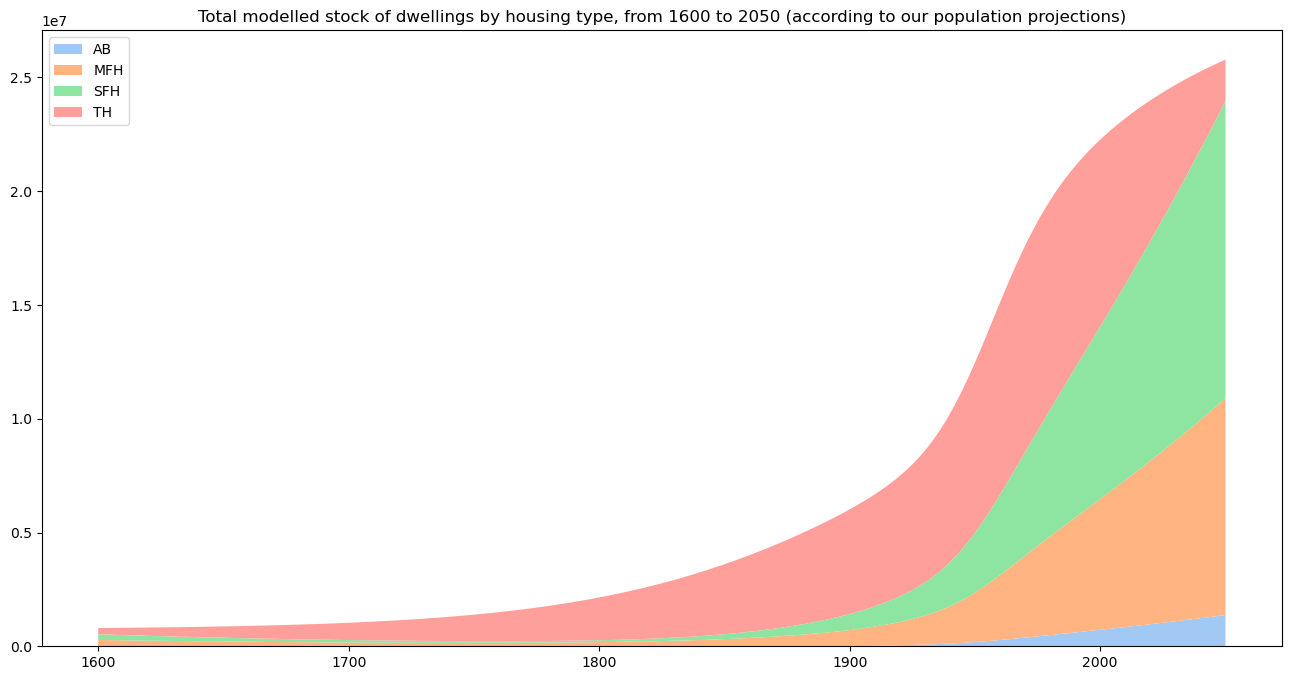

In [31]:
# The shares are taken into account in script 2 - for the inflow 

display(DSM)
display(DSM_AB)

DSM.to_csv("Model/DSM_TOT.csv")
DSM_AB.to_csv("Model/DSM_AB.csv")
DSM_MFH.to_csv("Model/DSM_MFH.csv")
DSM_SFH.to_csv("Model/DSM_SFH.csv")
DSM_TH.to_csv("Model/DSM_TH.csv")

Hyp: the differences in lifetime between dwelling types is negligeable for the above share in stock. 
However, we will use them for inflow-outflow modelling. 